In [1]:
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load Model Outputs

In [2]:
# Load the file
# pt_file = torch.load("experiments/SINDDataset_evaluation_2024-03-07_outputs_all/outut_data.pt")
pt_file = torch.load("experiments/SINDDataset_evaluation_epochs150_chunks90_2024-03-11_13-00-33_7VY/outut_data.pt")

# Print the head of the file
print(pt_file.keys())

dict_keys(['target_masks', 'targets', 'predictions', 'metrics', 'IDs', 'padding_masks', 'embeddings', 'embeddings_original'])


In [3]:
print(len(pt_file['embeddings'])) # (37, 256, 60, 128) -> number of batches, batch size, chunck size, embedding size
print(len(pt_file['embeddings'][0]))
print(len(pt_file['embeddings'][0][0]))
print(len(pt_file['embeddings'][0][0][0]))

26
256
90
128


In [4]:
all_data = np.concatenate(pt_file['targets'], axis=0)
all_embeddings = np.concatenate(pt_file['embeddings'], axis=0)
all_embeddings_original = np.concatenate(pt_file['embeddings_original'], axis=0)
all_predictions = np.concatenate(pt_file['predictions'], axis=0)
padding_masks = np.concatenate(pt_file['padding_masks'], axis=0)

In [5]:
all_data.shape, all_embeddings.shape, padding_masks.shape

((6460, 90, 6), (6460, 90, 128), (6460, 90))

# Display Data in Map

In [6]:
batch_id = 2

In [7]:
import osmium as osm
from src.datasets.plot import SinDMap
from shapely.geometry import Point

In [8]:
class OSMHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.nodes = []

    def node(self, n):
        self.nodes.append((n.location.lat, n.location.lon))

handler = OSMHandler()
handler.apply_file('resources/SinD/Data/mapfile-Tianjin.osm')

In [9]:
# print map
# fig, ax = plt.subplots()
# fig.set_size_inches(6.5, 4.13)
# fig.subplots_adjust(top=0.95, left=0.08, bottom=0.1, right=0.95)
# map = SinD_map() # cpfl(map)
# ax = map.plot_areas(ax=ax)
# plt.show()

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


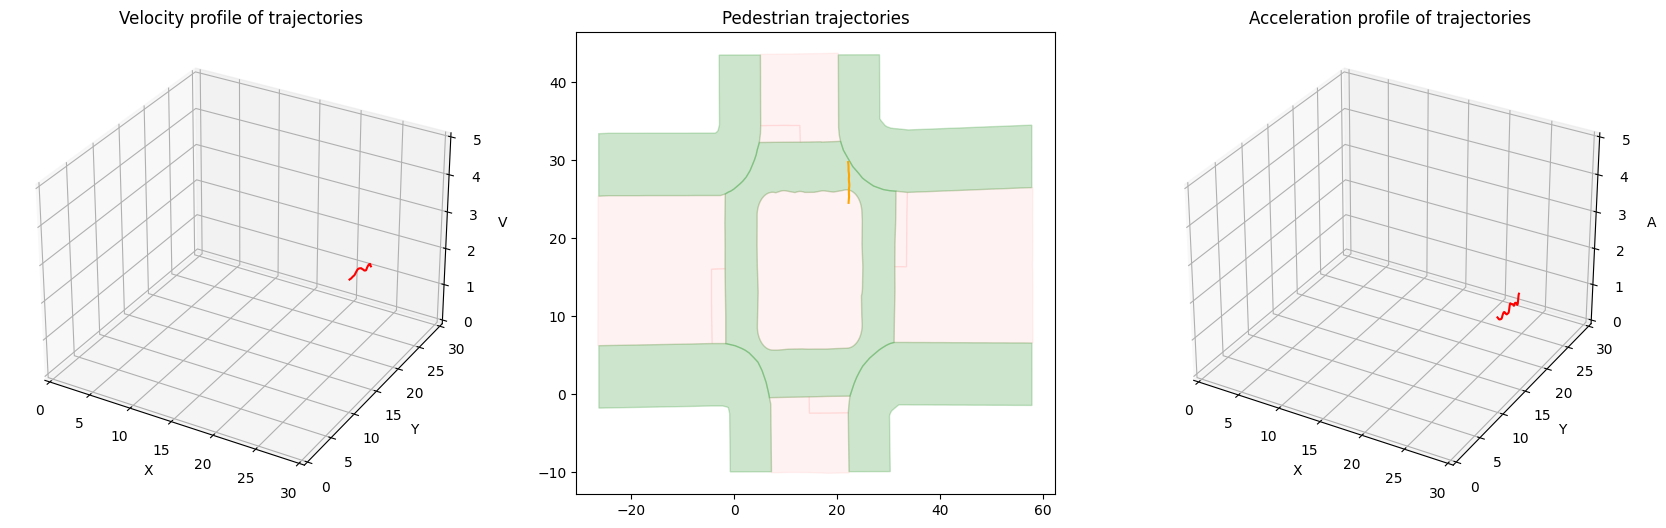

In [10]:
map = SinDMap()
map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(all_data[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=padding_masks)

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


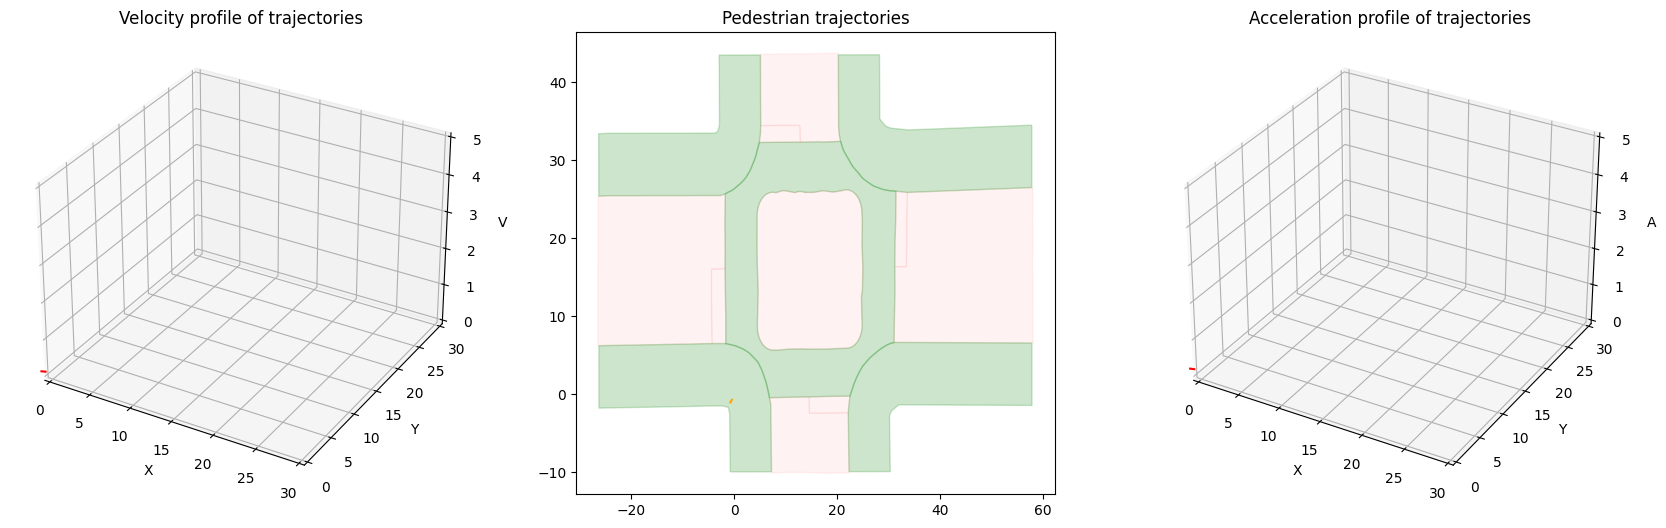

In [11]:
map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(all_predictions[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=padding_masks)

In [12]:
# projected_down_embedding = TSNE(n_components=6, method='exact').fit_transform(all_embeddings_original[batch_id])
# map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(projected_down_embedding, columns=["x", "y", "vx", "vy", "ax", "ay"])})

In [13]:
# projected_down_embedding = TSNE(n_components=6, method='exact').fit_transform(all_embeddings[batch_id])
# map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(projected_down_embedding, columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=padding_masks)

### Full Dataset

In [14]:
trajectories_per_sidewalk = {0: [], 1: [], 2: [], 3: []}
rest_trajectories = {'gap': [], 'road': [], 'inter': [], 'crosswalk': []}
for key, trajectory in enumerate(all_data):
    trajectory = pd.DataFrame(trajectory, columns=["x", "y", "vx", "vy", "ax", "ay"])
    _trajectory_x, _trajectory_y = np.array(trajectory['x']), np.array(trajectory['y'])
    start_point = Point((_trajectory_x[0], _trajectory_y[0]))
    for i in range(0, 4):
        if start_point.within(map.sidewalk_poly[i]) or start_point.touches(map.sidewalk_poly[i]):
            trajectories_per_sidewalk[i].append(key)
    
    if not start_point.within(map.sidewalk_poly) and not start_point.touches(map.sidewalk_poly):
        if start_point.within(map.gap_poly) or start_point.touches(map.gap_poly):
            rest_trajectories['gap'].append(key)
        if start_point.within(map.road_poly) or start_point.touches(map.road_poly):
            rest_trajectories['road'].append(key)
        if start_point.within(map.intersection_poly) or start_point.touches(map.intersection_poly):
            rest_trajectories['inter'].append(key)
        if start_point.within(map.crosswalk_poly) or start_point.touches(map.crosswalk_poly):
            rest_trajectories['crosswalk'].append(key)

/tmp/ipykernel_313058/929498283.py:8: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if start_point.within(map.sidewalk_poly[i]) or start_point.touches(map.sidewalk_poly[i]):


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


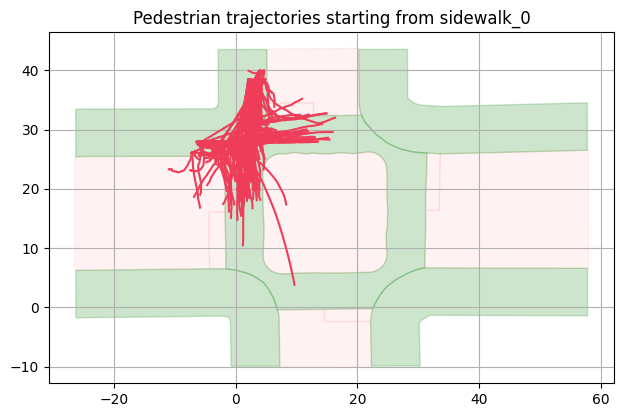

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


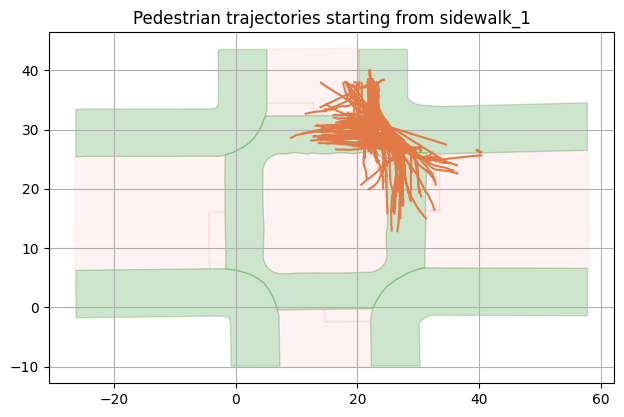

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


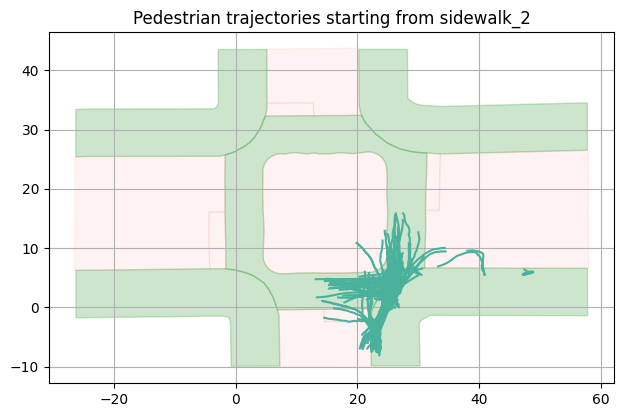

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


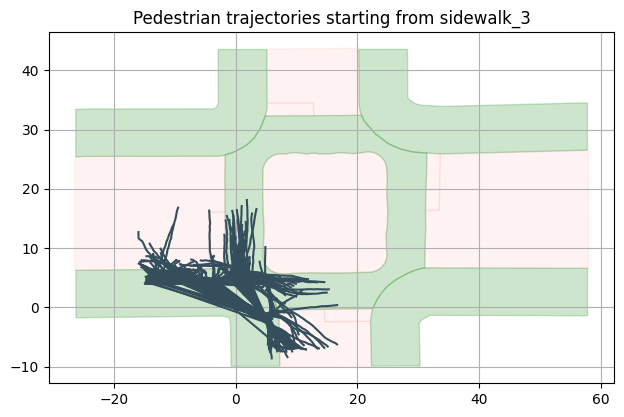

In [15]:
COLOR_PALETE = ['#EF3D59', '#E17A47', '#4AB19D',  '#344E5C']
for sidewalk_id, pedestrian_ids in trajectories_per_sidewalk.items():
    # Gather pedestrian data for this sidewalk
    sidewalk_pedestrian_data = {pid: all_data[pid] for pid in pedestrian_ids}

    # Plot the data for this sidewalk
    plot = map.plot_dataset(pedestrian_data=sidewalk_pedestrian_data, color=COLOR_PALETE[sidewalk_id], title=f'sidewalk_{sidewalk_id}', padding_masks=padding_masks)


# Clustering

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [17]:
COLOR_PALETE = ['#EF3D59', '#E17A47', '#EFC958', '#4AB19D',  '#344E5C', '#A6206A', '#568EA6', '#A2D4AB', '#5A5050']
n_clusters =5

In [18]:
pd.set_option('display.max_columns', None)

In [19]:
# Flatten the sequence_length and features dimensions
df_predicted = pd.DataFrame(all_embeddings.reshape(all_embeddings.shape[0], -1)) # flatten data merge first two dimensions
df_target = pd.DataFrame(all_data.reshape(all_data.shape[0], -1)) # flatten data merge first two dimensions

In [20]:
# # Find right number of clusters
# df_predicted_test = df_predicted

# for n_ in range(2, 26):
#     kmeans = KMeans(n_clusters=n_)  # clusters
#     df_predicted_test['clusters'] = kmeans.fit_predict(df_predicted_test)

#     score = silhouette_score(df_predicted_test.iloc[:, :-1], df_predicted_test['cluster'])
#     print("Silhouette Score: ", score, ", n_clusters:", n_)

In [21]:
all_data.shape

(6460, 90, 6)

In [22]:
# Perform K-Means clustering
# Encoded embeddings where created throuth a transformer model that was designed to ignore the padded values
kmeans = KMeans(n_clusters=n_clusters)  # Choose an appropriate number of clusters
df_predicted['clusters'] = kmeans.fit_predict(df_predicted)

score = silhouette_score(df_predicted.iloc[:, :-1], df_predicted['clusters'])
print("Silhouette Score: ", score)

Silhouette Score:  0.2027194


In [23]:
df_predicted.shape,  df_target.shape

((6460, 11521), (6460, 540))

##### X vs Y plots

In [24]:
df_target.shape, padding_masks.shape

((6460, 540), (6460, 90))

In [25]:
trajectories = {cluster: {} for cluster in df_predicted['clusters'].unique()}
trajectories_masked = {cluster: {} for cluster in df_predicted['clusters'].unique()}
for cluster in df_predicted['clusters'].unique():
    cluster_df = df_target[df_predicted['clusters'] == cluster]

    for index, row in cluster_df.iterrows():
        mask = padding_masks[index] # mask padded values
        trajectories_masked[cluster][index] = row.values.reshape(-1, 6)[mask] # last column is the cluster
        trajectories[cluster][index] = row.values.reshape(-1, 6) # last column is the cluster

Coordinates in Map

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


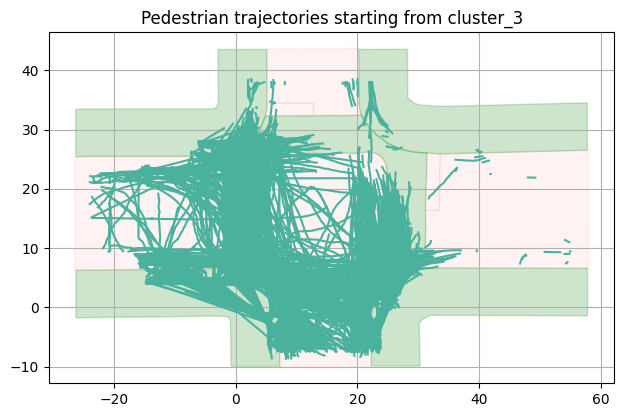

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


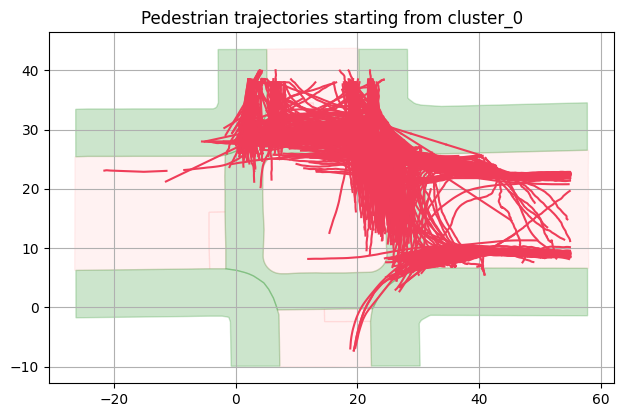

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


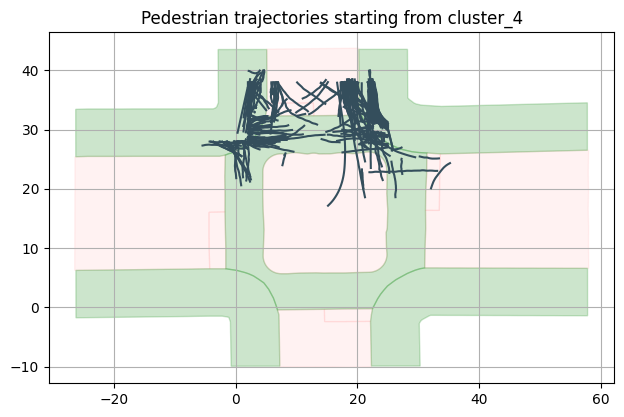

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


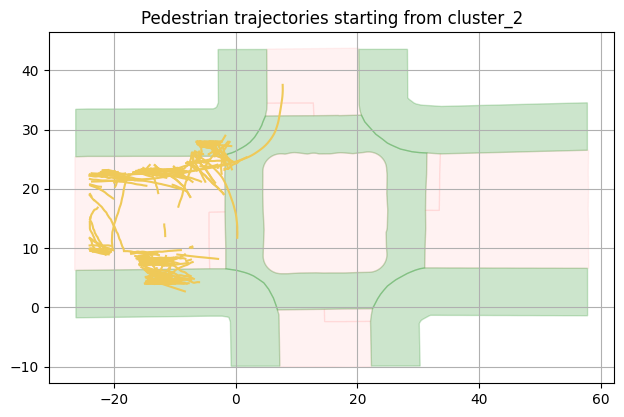

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


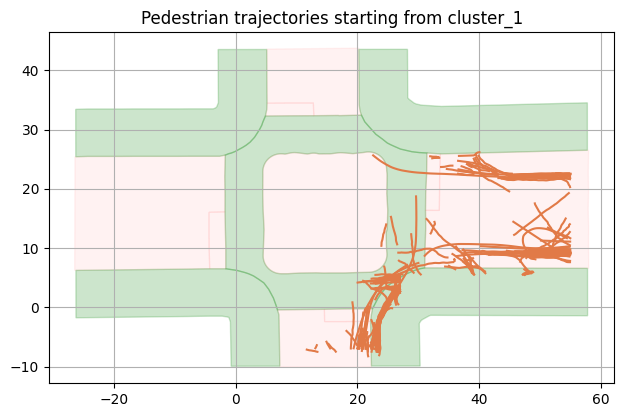

In [26]:
for cluster in df_predicted['clusters'].unique():
    cluster_df = df_target[df_predicted['clusters'] == cluster]

    trajectories = {}
    for index, row in cluster_df.iterrows():
        trajectories[index] = row.values.reshape(-1, 6) # last column is the cluster
    
    map.plot_dataset(pedestrian_data=trajectories, color=COLOR_PALETE[cluster], title=f'cluster_{cluster}', padding_masks=padding_masks)

### Extra

X vs Time

In [27]:
clusters = trajectories_masked.keys()
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

plt.figure(figsize=(14, 8))

# Assuming you have a way to iterate over trajectories and know their cluster
for cluster_index, color in zip(clusters, colors):
    cluster_indices = list(trajectories_masked[cluster_index].keys())

    for id, trajectory in trajectories_masked[cluster_index].items():
        time_indices = np.arange(len(trajectory))  # Time steps
        x_values = trajectory[:, 0]  # 'x' feature
        
        # Only label the first trajectory for each cluster in the legend to avoid duplicates
        if id == cluster_indices[0]:
            plt.plot(time_indices, x_values, color=color, label=f'Cluster {cluster}')
        else:
            plt.plot(time_indices, x_values, color=color)

plt.xlabel('Time')
plt.ylabel('X Feature')
plt.title('Trajectories X Feature Over Time by Cluster')
plt.legend()
plt.show()

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Y vs Time 

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


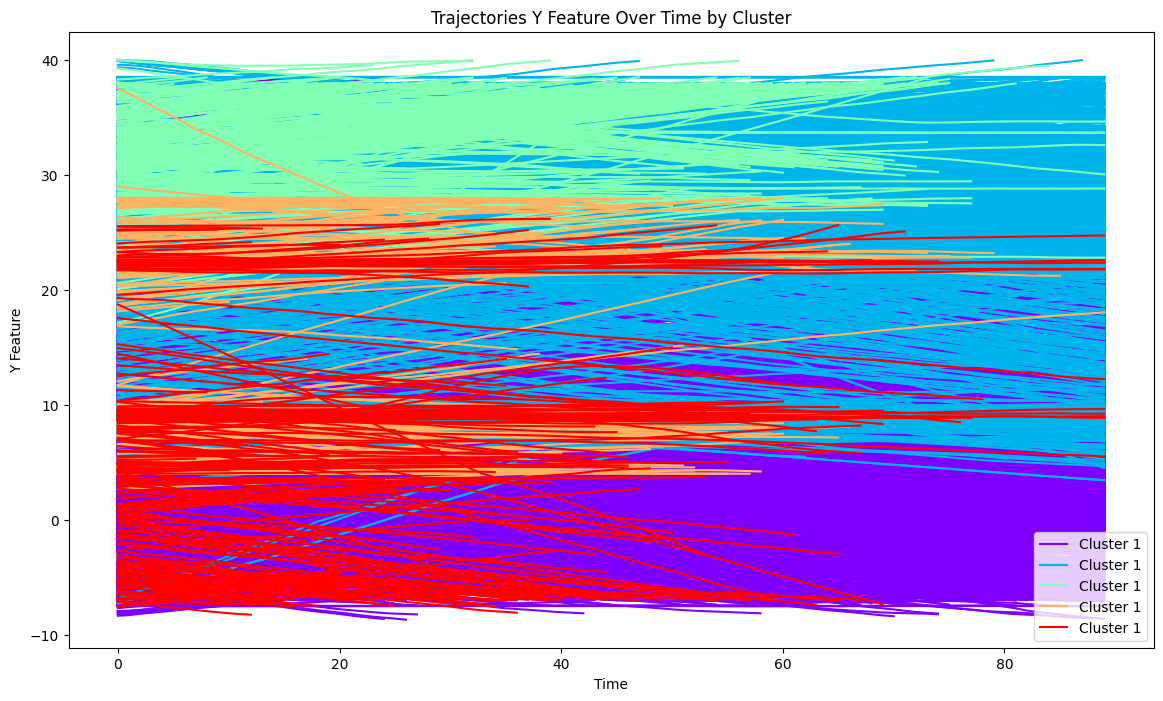

In [ ]:
clusters = trajectories_masked.keys()
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

plt.figure(figsize=(14, 8))

# Assuming you have a way to iterate over trajectories and know their cluster
for cluster_index, color in zip(clusters, colors):
    cluster_indices = list(trajectories_masked[cluster_index].keys())

    for id, trajectory in trajectories_masked[cluster_index].items():
        time_indices = np.arange(len(trajectory))  # Time steps
        y_values = trajectory[:, 1]  # 'y' feature
        
        # Only label the first trajectory for each cluster in the legend to avoid duplicates
        if id == cluster_indices[0]:
            plt.plot(time_indices, y_values, color=color, label=f'Cluster {cluster}')
        else:
            plt.plot(time_indices, y_values, color=color)

plt.xlabel('Time')
plt.ylabel('Y Feature')
plt.title('Trajectories Y Feature Over Time by Cluster')
plt.legend()
plt.show()

##### Velocit vs Time 

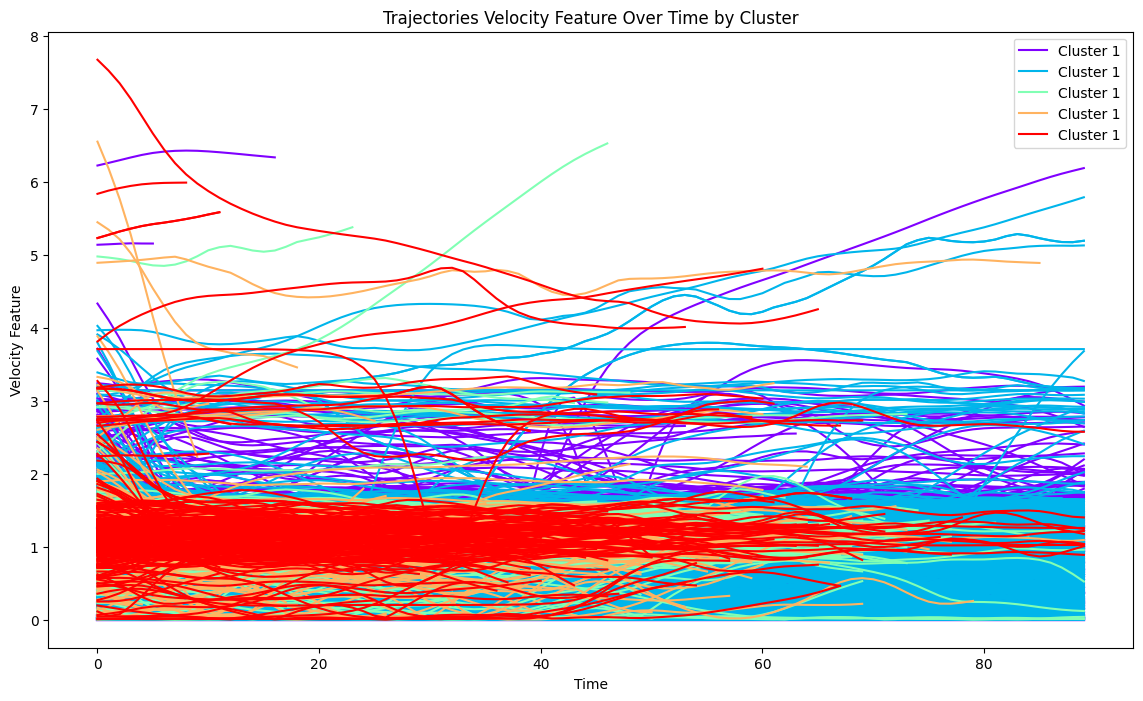

In [ ]:
clusters = trajectories_masked.keys()
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

plt.figure(figsize=(14, 8))

# Assuming you have a way to iterate over trajectories and know their cluster
for cluster_index, color in zip(clusters, colors):
    cluster_indices = list(trajectories_masked[cluster_index].keys())

    for id, trajectory in trajectories_masked[cluster_index].items():
        time_indices = np.arange(len(trajectory))  # Time steps
        vx, vy = trajectory[:, 2], trajectory[:, 3]
        v_values = np.sqrt(np.square(vx) + np.square(vy)) # 'v' feature
        
        # Only label the first trajectory for each cluster in the legend to avoid duplicates
        if id == cluster_indices[0]:
            plt.plot(time_indices, v_values, color=color, label=f'Cluster {cluster}')
        else:
            plt.plot(time_indices, v_values, color=color)

plt.xlabel('Time')
plt.ylabel('Velocity Feature')
plt.title('Trajectories Velocity Feature Over Time by Cluster')
plt.legend()
plt.show()

Vx vs Time

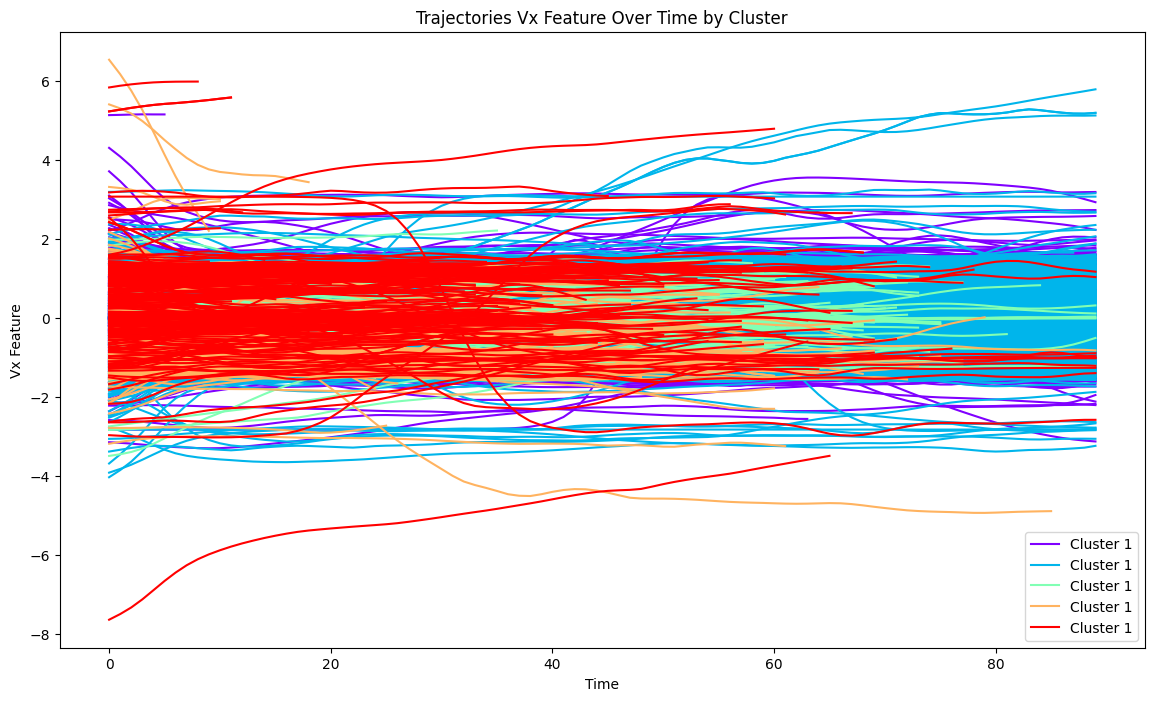

In [ ]:
clusters = trajectories_masked.keys()
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

plt.figure(figsize=(14, 8))

# Assuming you have a way to iterate over trajectories and know their cluster
for cluster_index, color in zip(clusters, colors):
    cluster_indices = list(trajectories_masked[cluster_index].keys())

    for id, trajectory in trajectories_masked[cluster_index].items():
        time_indices = np.arange(len(trajectory))  # Time steps
        vx_values = trajectory[:, 2]  # 'vx' feature
        
        # Only label the first trajectory for each cluster in the legend to avoid duplicates
        if id == cluster_indices[0]:
            plt.plot(time_indices, vx_values, color=color, label=f'Cluster {cluster}')
        else:
            plt.plot(time_indices, vx_values, color=color)

plt.xlabel('Time')
plt.ylabel('Vx Feature')
plt.title('Trajectories Vx Feature Over Time by Cluster')
plt.legend()
plt.show()

Vy vs Time 

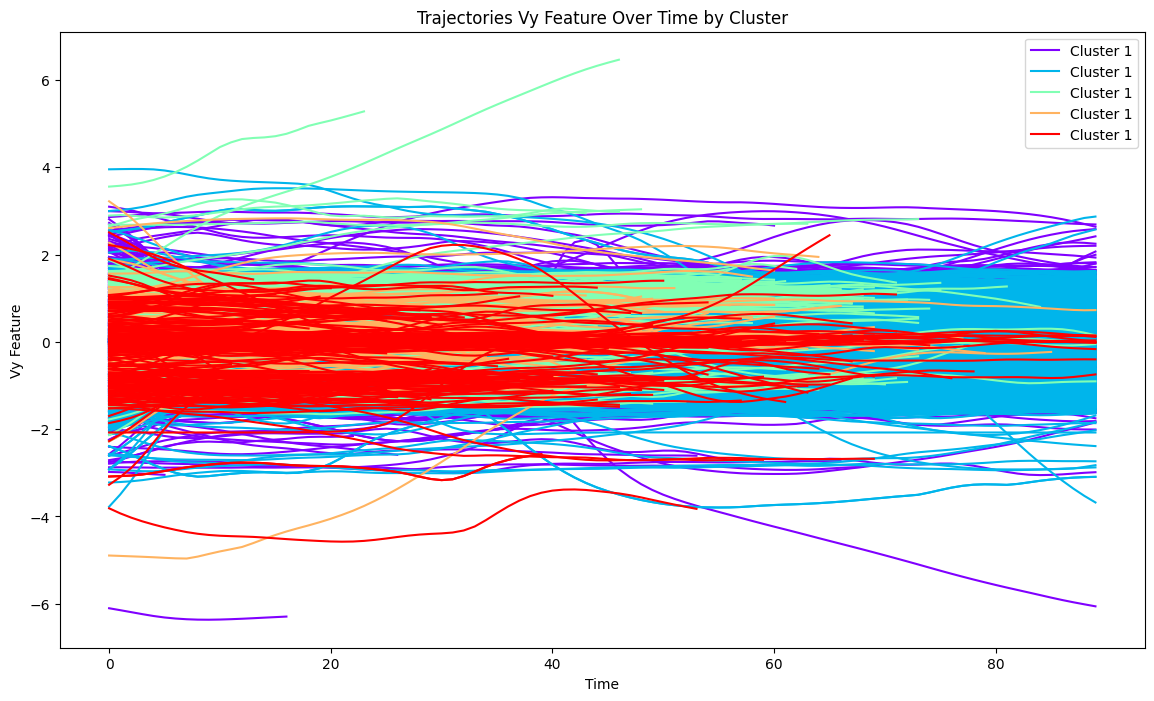

In [ ]:
clusters = trajectories_masked.keys()
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

plt.figure(figsize=(14, 8))

# Assuming you have a way to iterate over trajectories and know their cluster
for cluster_index, color in zip(clusters, colors):
    cluster_indices = list(trajectories_masked[cluster_index].keys())

    for id, trajectory in trajectories_masked[cluster_index].items():
        time_indices = np.arange(len(trajectory))  # Time steps
        vy_values = trajectory[:, 3]  # 'vy' feature
        
        # Only label the first trajectory for each cluster in the legend to avoid duplicates
        if id == cluster_indices[0]:
            plt.plot(time_indices, vy_values, color=color, label=f'Cluster {cluster}')
        else:
            plt.plot(time_indices, vy_values, color=color)

plt.xlabel('Time')
plt.ylabel('Vy Feature')
plt.title('Trajectories Vy Feature Over Time by Cluster')
plt.legend()
plt.show()

##### Acceleration vs Time 

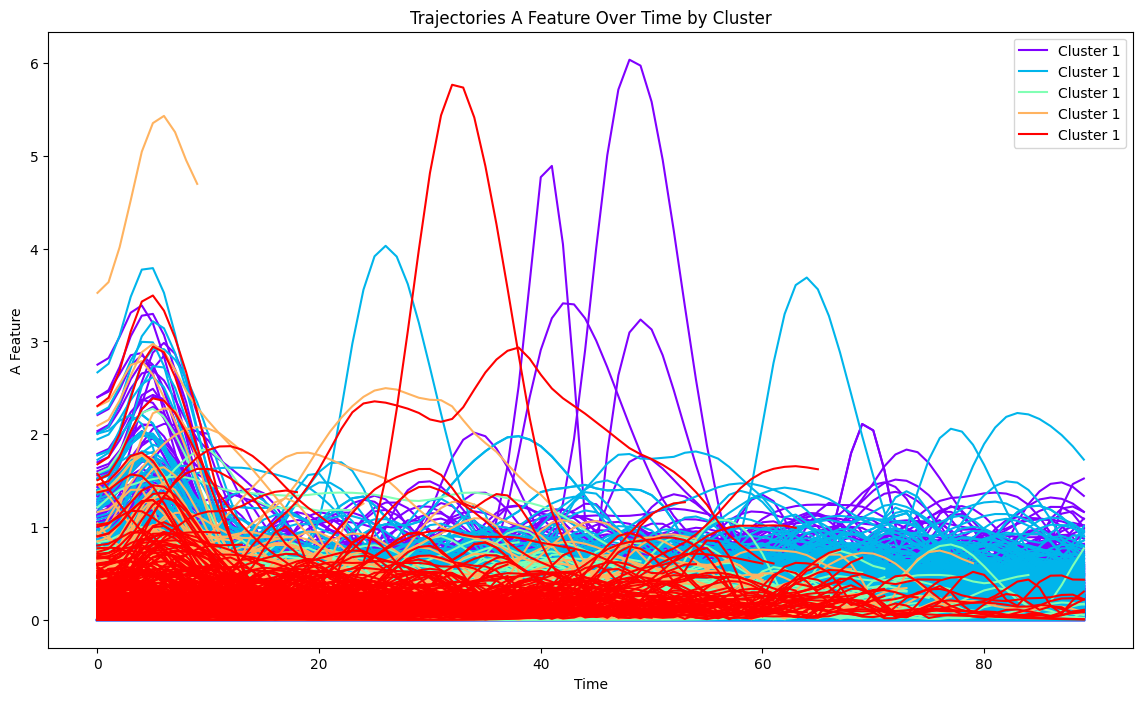

In [ ]:
clusters = trajectories_masked.keys()
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

plt.figure(figsize=(14, 8))

# Assuming you have a way to iterate over trajectories and know their cluster
for cluster_index, color in zip(clusters, colors):
    cluster_indices = list(trajectories_masked[cluster_index].keys())

    for id, trajectory in trajectories_masked[cluster_index].items():
        time_indices = np.arange(len(trajectory))  # Time steps
        ax, ay = trajectory[:, 4], trajectory[:, 5]
        a_values = np.sqrt(np.square(ax) + np.square(ay)) # 'v' feature
        
        # Only label the first trajectory for each cluster in the legend to avoid duplicates
        if id == cluster_indices[0]:
            plt.plot(time_indices, a_values, color=color, label=f'Cluster {cluster}')
        else:
            plt.plot(time_indices, a_values, color=color)

plt.xlabel('Time')
plt.ylabel('A Feature')
plt.title('Trajectories A Feature Over Time by Cluster')
plt.legend()
plt.show()

Ax vs Time

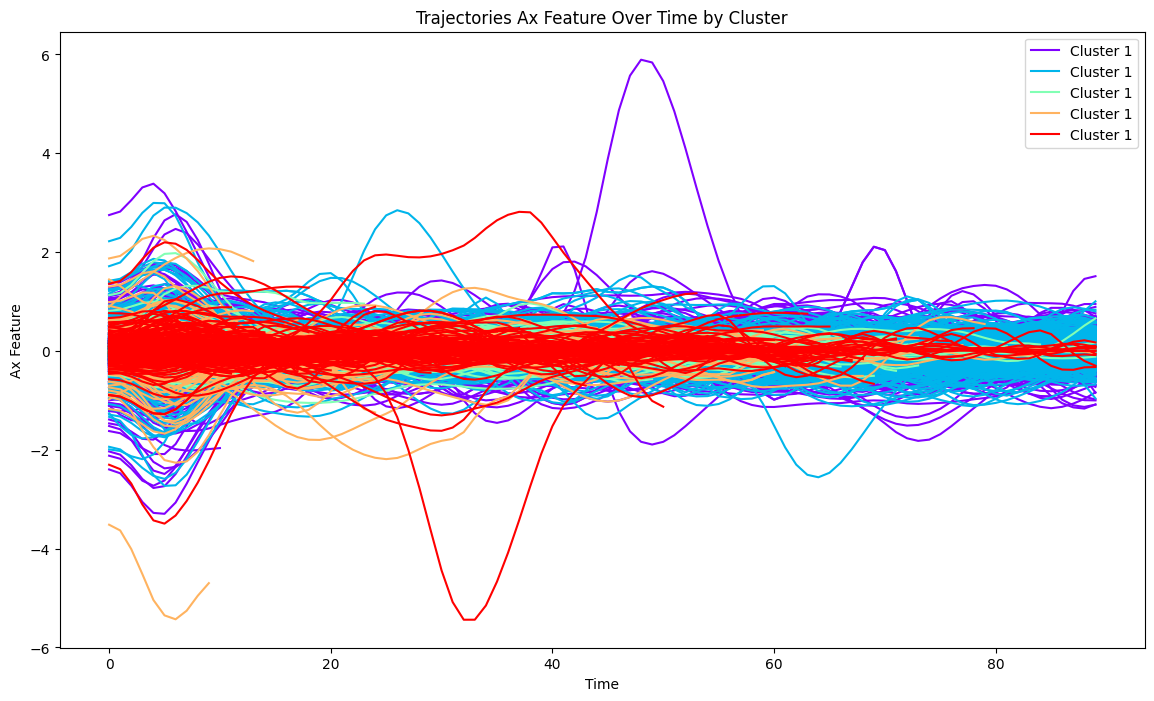

In [ ]:
clusters = trajectories_masked.keys()
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

plt.figure(figsize=(14, 8))

# Assuming you have a way to iterate over trajectories and know their cluster
for cluster_index, color in zip(clusters, colors):
    cluster_indices = list(trajectories_masked[cluster_index].keys())

    for id, trajectory in trajectories_masked[cluster_index].items():
        time_indices = np.arange(len(trajectory))  # Time steps
        ax_values = trajectory[:, 4]  # 'ax' feature
        
        # Only label the first trajectory for each cluster in the legend to avoid duplicates
        if id == cluster_indices[0]:
            plt.plot(time_indices, ax_values, color=color, label=f'Cluster {cluster}')
        else:
            plt.plot(time_indices, ax_values, color=color)

plt.xlabel('Time')
plt.ylabel('Ax Feature')
plt.title('Trajectories Ax Feature Over Time by Cluster')
plt.legend()
plt.show()

Ay vs Time 

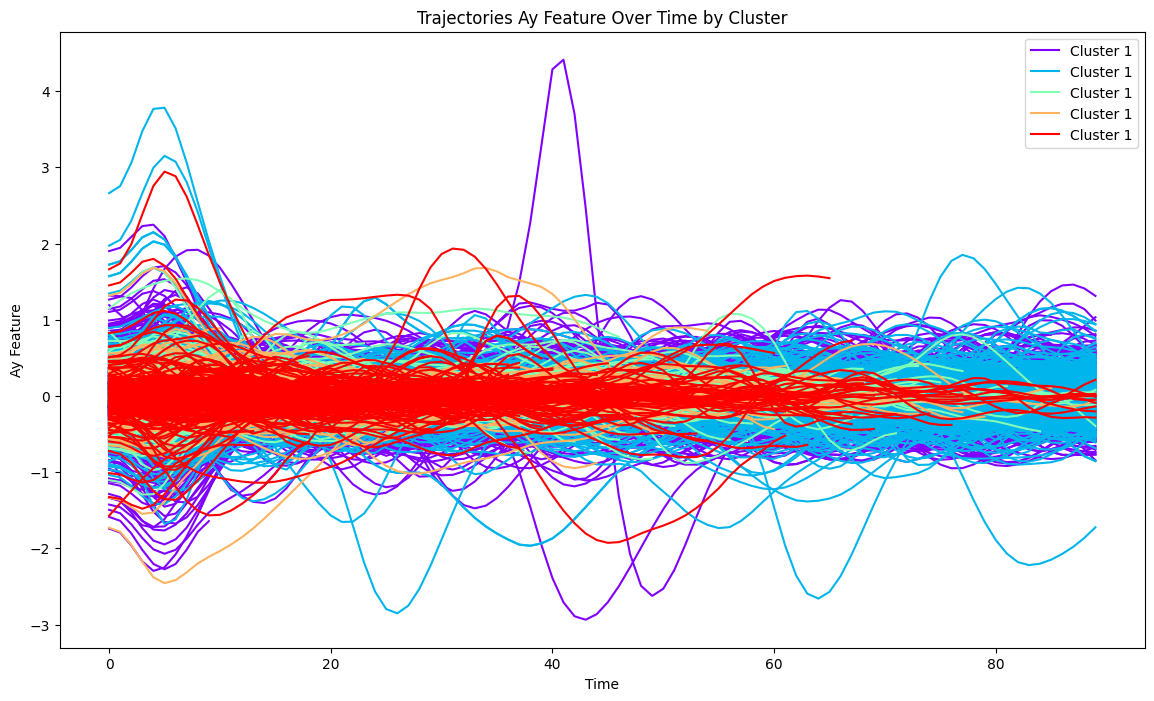

In [ ]:
clusters = trajectories_masked.keys()
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

plt.figure(figsize=(14, 8))

# Assuming you have a way to iterate over trajectories and know their cluster
for cluster_index, color in zip(clusters, colors):
    cluster_indices = list(trajectories_masked[cluster_index].keys())

    for id, trajectory in trajectories_masked[cluster_index].items():
        time_indices = np.arange(len(trajectory))  # Time steps
        ay_values = trajectory[:, 5]  # 'ay' feature
        
        # Only label the first trajectory for each cluster in the legend to avoid duplicates
        if id == cluster_indices[0]:
            plt.plot(time_indices, ay_values, color=color, label=f'Cluster {cluster}')
        else:
            plt.plot(time_indices, ay_values, color=color)

plt.xlabel('Time')
plt.ylabel('Ay Feature')
plt.title('Trajectories Ay Feature Over Time by Cluster')
plt.legend()
plt.show()

### Clusters Previous Analysis

In [ ]:
# Now `clusters` contains the cluster assignment for each sequence in your batch
df = df_target
df['clusters'] = df_predicted['clusters']
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=df_predicted.columns[:-1])  # Assuming the last column is 'cluster'
cluster_sizes = df['clusters'].value_counts()
cluster_profiles = df.groupby('clusters').mean()

In [ ]:
# The last column is the cluster assignment
clusters = df.iloc[:, -1]

# Reshape the DataFrame to calculate means for each feature
# Each feature has 60 values; we reshape and calculate the mean across the 60 steps
feature_means = pd.DataFrame({
    'x_mean': df.iloc[:, 0::6].mean(axis=1),
    'y_mean': df.iloc[:, 1::6].mean(axis=1),
    'vx_mean': df.iloc[:, 2::6].mean(axis=1),
    'vy_mean': df.iloc[:, 3::6].mean(axis=1),
    'ax_mean': df.iloc[:, 4::6].mean(axis=1),
    'ay_mean': df.iloc[:, 5::6].mean(axis=1),
    'cluster': clusters
})

# Now, group by the cluster and calculate the mean of these averages for each cluster
cluster_means = feature_means.groupby('cluster').mean()

In [ ]:
cluster_profiles.shape, cluster_means.shape

((5, 540), (5, 6))

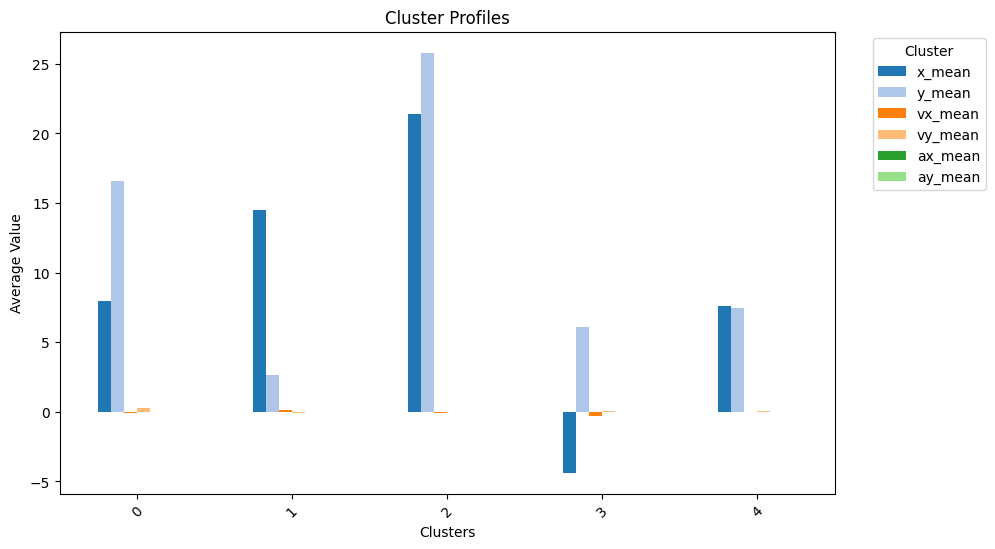

In [ ]:
# Use the tab20 colormap
colormap = plt.cm.tab20.colors  # Tab20 colormap with 20 unique colors

# Transpose cluster_means for plotting if your DataFrame has clusters as rows and features as columns
cluster_profiles = cluster_means

# Plot
cluster_profiles.plot(kind='bar', figsize=(10, 6), color=colormap[:cluster_profiles.shape[1]])
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title="Cluster")
plt.title("Cluster Profiles")
plt.xlabel("Clusters")
plt.ylabel("Average Value")
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.show()

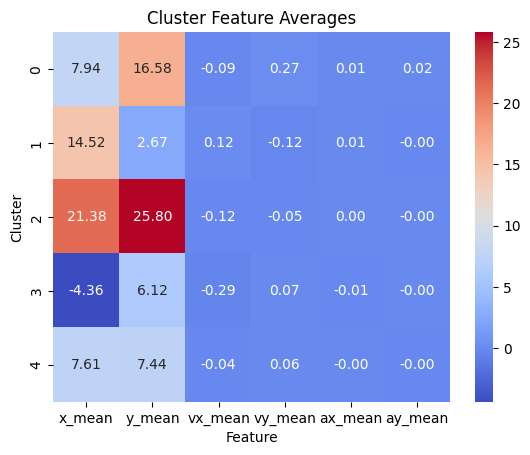

In [ ]:
import seaborn as sns

# Assuming cluster_means is your DataFrame with clusters as rows and features as columns
sns.heatmap(cluster_means, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cluster Feature Averages')
plt.xlabel('Feature')
plt.ylabel('Cluster')
plt.show()

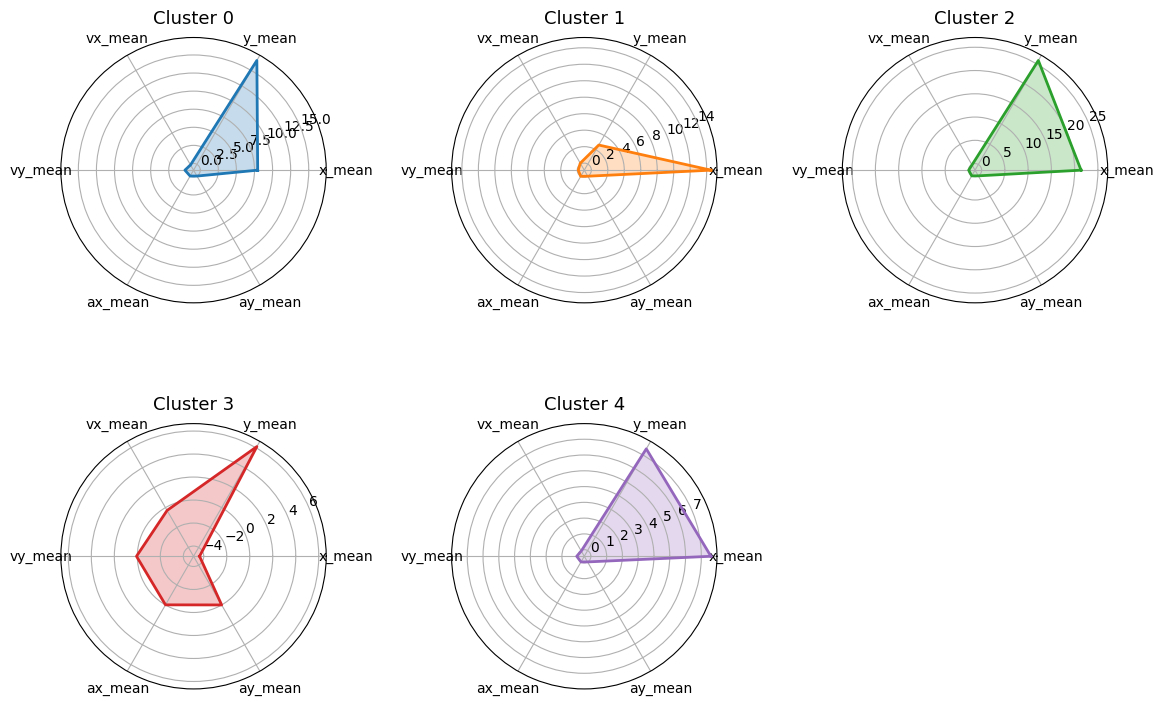

In [ ]:
import matplotlib.pyplot as plt
import math

def draw_radar_chart(ax, angles, values, feature_labels, color, title):
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_labels)
    ax.set_title(title, position=(0.5, 1.1), fontsize=13)

def plot_cluster_radar_charts(cluster_means, features, rows=None, cols=None):
    # Calculate the angles for each feature
    num_vars = len(features)
    angles = [n / float(num_vars) * 2 * math.pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop to close the radar chart
    
    # Determine subplot layout if not specified
    num_clusters = len(cluster_means.index)
    if not rows or not cols:
        cols = int(np.ceil(np.sqrt(num_clusters)))
        rows = int(np.ceil(num_clusters / cols))

    # Initialize the radar chart
    fig, axs = plt.subplots(figsize=(cols * 4, rows * 4), nrows=rows, ncols=cols, subplot_kw=dict(polar=True))
    fig.subplots_adjust(hspace=0.6, wspace=0.6)
    axs = axs.ravel()  # Flatten the axs for easy iteration
    
    # Plot each cluster's radar chart
    for i, (idx, row) in enumerate(cluster_means.iterrows()):
        data = row.tolist() + row.tolist()[:1]  # Extend the data to close the radar chart
        draw_radar_chart(axs[i], angles, data, features, plt.cm.tab10(i % 10), f'Cluster {idx}')
    
    # Hide unused subplots if any
    for i in range(num_clusters, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout(pad=2)
    plt.show()

# Example usage:
features = ['x_mean', 'y_mean', 'vx_mean', 'vy_mean', 'ax_mean', 'ay_mean']  # Define your features list
plot_cluster_radar_charts(cluster_means, features)


In [ ]:
# import matplotlib.pyplot as plt
# import math

# def draw_radar_chart(ax, angles, values, feature_labels, color, title):
#     ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
#     ax.fill(angles, values, color=color, alpha=0.25)
#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(feature_labels)
#     ax.set_title(title, position=(0.5, 1.1), fontsize=13)

# def plot_cluster_radar_charts(cluster_means, features, rows=None, cols=None):
#     # Calculate the angles for each feature
#     num_vars = len(features)
#     angles = [n / float(num_vars) * 2 * math.pi for n in range(num_vars)]
#     angles += angles[:1]  # Complete the loop to close the radar chart
    
#     # Determine subplot layout if not specified
#     num_clusters = len(cluster_means.index)
#     if not rows or not cols:
#         cols = int(np.ceil(np.sqrt(num_clusters)))
#         rows = int(np.ceil(num_clusters / cols))

#     # Initialize the radar chart
#     fig, axs = plt.subplots(figsize=(cols * 4, rows * 4), nrows=rows, ncols=cols, subplot_kw=dict(polar=True))
#     fig.subplots_adjust(hspace=0.6, wspace=0.6)
#     axs = axs.ravel()  # Flatten the axs for easy iteration
    
#     # Plot each cluster's radar chart
#     for i, (idx, row) in enumerate(cluster_means.iterrows()):
#         data = row.tolist() + row.tolist()[:1]  # Extend the data to close the radar chart
#         draw_radar_chart(axs[i], angles, data, features, plt.cm.tab10(i % 10), f'Cluster {idx}')
    
#     # Hide unused subplots if any
#     for i in range(num_clusters, len(axs)):
#         fig.delaxes(axs[i])

#     plt.tight_layout(pad=2)
#     plt.show()

# # Example usage:
# features = ['x_mean', 'y_mean', 'vx_mean', 'vy_mean', 'ax_mean', 'ay_mean']  # Define your features list => get PCA for each point instead of x_mean ()
# plot_cluster_radar_charts(cluster_means, features)


In [ ]:
cluster_profiles

x_mean     y_mean   vx_mean   vy_mean   ax_mean   ay_mean
cluster                                                              
0         7.941784  16.582430 -0.094156  0.267332  0.013079  0.015420
1        14.515695   2.668944  0.123472 -0.121471  0.012056 -0.003896
2        21.379099  25.804134 -0.117559 -0.047493  0.004007 -0.000697
3        -4.363400   6.124366 -0.286382  0.071420 -0.010953 -0.001049
4         7.609230   7.444853 -0.035818  0.061423 -0.002386 -0.004632

### PCA 

In [ ]:
# Creating a 3D scatter plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Extracting the cluster names and colors
# clusters = df['clusters'].unique()
# colors = COLOR_PALETE if n_clusters <= len(COLOR_PALETE) else sns.color_palette('tab20', len(clusters))  # Tab20 colormap with 20 unique colors

# for cluster, color in zip(clusters, colors):
#     cluster_data = df[df['clusters'] == cluster]
#     ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], s=.6, alpha=0.6, label=f'Cluster {cluster}', color=color)


In [ ]:
# # Set the threshold for highlighting
# threshold = 0.1

# # Number of principal components
# num_pcs = 3

# plt.figure(figsize=(num_pcs*7, 8))

# # Iterate through the first three PCs
# for i in range(num_pcs):
#     ax = plt.subplot(1, num_pcs, i+1)
#     bars = ax.barh(df.columns, loadings[i, :])
    
#     # Color feature names red if the bar is above 0.2
#     # Color feature names red if the bar is above 0.2 and adjust x-tick labels
#     for bar, label in zip(bars, ax.get_yticklabels()):
#         label.set_color('red' if abs(bar.get_width()) > threshold else 'black')


#      # Add a red horizontal line at the threshold
#     ax.axvline(x=threshold, color='red', linestyle='--')
#     ax.axvline(x=-threshold, color='red', linestyle='--')  # For negative values
    
#     ax.set_yticklabels(df.columns, ha='right')

#     plt.xlabel('Loading')
#     plt.title(f'Loadings for PC{i+1}')

# plt.tight_layout()
# plt.show()